In [206]:
import torch
import numpy as np
import os
import cma
# from eval import play
import random

from gan.config import BaseConfig, ZeldaConfig, MarioConfig
from gan.models.general_models import Generator
from play_rl.zelda_astar import play_astar
from gan.utils import tensor_to_level_str, check_playable
from gan.level_visualizer import GVGAILevelVisualizer,MarioLevelVisualizer
from gan.game.env import Game
from gan.game.zelda import Zelda
from gan.game.mario import Mario
from play_rl.wrappers import GridGame
from play_rl.policy import Policy
from PIL import Image


In [207]:
game = Mario()
config = MarioConfig()
config.set_env(game)


def get_model(game: Game, config: BaseConfig):
    # reproducible settings
    random.seed(config.seed)
    np.random.seed(config.seed)
    torch.manual_seed(config.seed)
    torch.cuda.manual_seed(config.seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    device = torch.device('cpu')
    # device = torch.device(
    #     f'cuda:{config.gpu_id}' if torch.cuda.is_available() else 'cpu')
    generator = Generator(
        isize=game.input_shape[1], nz=config.latent_size, nc=game.input_shape[
            0], ngf=config.generator_filters, self_attention=config.use_self_attention_g, n_extra_layers=config.extra_layers_g
    ).to(device)
    return generator


level_visualizer = MarioLevelVisualizer(game,config.data_path)
generator = get_model(game, config)
model_save_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/mario_v0/new-43"
model_dict = torch.load(os.path.join(model_save_path, "latest.tar"))
generator.load_state_dict(model_dict['generator'])


<All keys matched successfully>

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1095435, Sun Jan 29 00:27:49 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 5.600000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 5.200000000000000e+01 1.1e+00 4.51e-01  4e-01  5e-01 0:00.4
    3     42 4.800000000000000e+01 1.1e+00 4.28e-01  4e-01  4e-01 0:00.5
   28    392 3.200000000000000e+01 1.7e+00 6.08e-01  6e-01  7e-01 0:03.6
   57    798 2.800000000000000e+01 2.4e+00 1.00e+00  9e-01  1e+00 0:07.6
   69    966 2.800000000000000e+01 2.5e+00 9.45e-01  9e-01  1e+00 0:09.4
   74   1036 2.800000000000000e+01 2.6e+00 9.01e-01  8e-01  1e+00 0:10.1
   75   1050 2.800000000000000e+01 2.6e+00 9.00e-01  8e-01  1e+00 0:10.3
   76   1064 2.800000000000000e+01 2.6e+00 8.74e-01  8e-01  1e+00 0:10.4
   77   1078 2.800000000000000e+01 2.6e+00 8.54e-01  8e-01  1e+00 0:10.5
   78   1092 2.800000000000000e+01 2.6e+00 8.55e-01  8e-01  1e+00 0:10.7
   85   1190 2.800000000000000e+

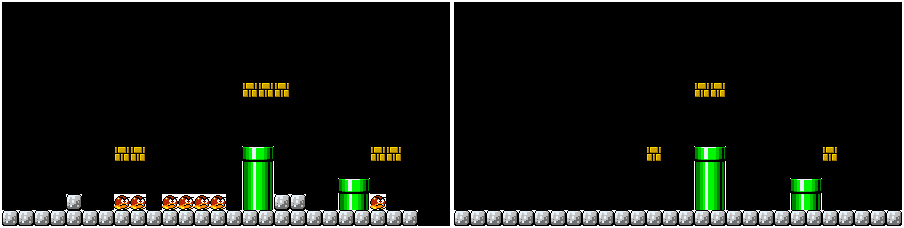

In [208]:
def f1(level_str):
    hole = 0
    block = 0
    enemy = 0
    pipe = 0
    level_str = level_str.split()
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if i==game.height-1 and c == '-':
                hole += 1
            if c == 'X':
                block += 1
            if c == 'E' and i < game.height and level_str[i + 1][j] != '-':
                enemy += 1
            if c == '<':
                pipe += 1
    return - 3 * hole - 3 * enemy - block


def f2(level_str):
    hole = 0
    block = 0
    enemy = 0
    pipe = 0
    level_str = level_str.split()
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if i == game.height - 1 and c == '-':
                hole += 1
            if c == 'X':
                block += 1
            if c == 'E':
                enemy += 1
            if c == '<':
                pipe += 1
    return 3 * hole + 3*enemy + block


def f3(level_str):
    hole = 0
    block = 0
    enemy = 0
    pipe = 0
    level_str = level_str.split()
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if i == game.height - 1 and c == '-':
                hole += 1
            if c == 'X':
                block += 1
            if c == 'E':
                enemy += 1
            if c == '<':
                pipe += 1
    return 3 * abs(hole-2) + 3*abs(enemy-3) + abs(block-40)

# # env = GridGame(config.env_name, 200, env_def.state_shape)
# # actor = Policy(env.observation_space.shape, env.action_space,base_kwargs={"recurrent": True})
# # actor.load_state_dict(torch.load('/root/mnt/GVGAI-GAN/play_rl/checkpoints/ppo/zelda_20220825102126.pt'))


def fitnessf1(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1)
    level, _ = generator(latent)
    level_str = game.level_tensor_to_strs(level)[0]
    playable = game.check_playable(level_str)
    if not playable:
        return 1000
    # reward,step,_ = play(level_str[0],env=env,actor=actor)
    # reward, step, _ = play_astar(level_str[0], env=env)
    # return -(reward*100+step)
    ev = f1(level_str)
    return ev


def fitnessf2(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1)
    level, _ = generator(latent)
    level_str = game.level_tensor_to_strs(level)[0]
    playable = game.check_playable(level_str)
    if not playable:
        return 1000
    # reward,step,_ = play(level_str[0],env=env,actor=actor)
    # reward, step, _ = play_astar(level_str[0], env=env)
    # return -(reward*100+step)
    ev = f2(level_str)
    return ev


def fitnessf3(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1)
    level, _ = generator(latent)
    level_str = game.level_tensor_to_strs(level)[0]
    playable = game.check_playable(level_str)
    if not playable:
        return 1000
    # reward,step,_ = play(level_str[0],env=env,actor=actor)
    # reward, step, _ = play_astar(level_str[0], env=env)
    # return -(reward*100+step)
    ev = f3(level_str)
    return ev


def show(x):
    latent = torch.FloatTensor(x).view(1, -1)
    p_level, _ = generator(latent)
    level_strs = game.level_tensor_to_strs(p_level)
    p_level_img = np.array(level_visualizer.draw_level(level_strs[0]))
    image = Image.fromarray(p_level_img)
    image.show()


def show2(x, x2):
    latent1, latent2 = torch.FloatTensor(x).view(
        1, -1), torch.FloatTensor(x2).view(1, -1)
    p_level, _ = generator(latent1)
    level_strs = game.level_tensor_to_strs(p_level)
    p_level_img1 = np.array(level_visualizer.draw_level(level_strs[0]))
    p_level, _ = generator(latent2)
    level_strs = game.level_tensor_to_strs(p_level)
    p_level_img2 = np.array(level_visualizer.draw_level(level_strs[0]))
    concated = np.concatenate([p_level_img1, p_level_img2], axis=1)
    image = Image.fromarray(concated)
    image.show()


x = torch.randn(config.latent_size)
es = cma.CMAEvolutionStrategy(x.tolist(), 0.5, {'verbose': 3})
# print(cma.CMAOptions('verb'))
# es.optimize(fitness,iterations=30,min_iterations=30)
es.optimize(fitnessf2, iterations=100, min_iterations=100)
best = np.array(es.best.get()[0])
# print("INIT: ", np.array(x.tolist()))
# print("BEST: ", best)
print("Fitness: ", fitnessf2(best))
show2(x,torch.FloatTensor(best))


In [209]:
def check(generator,fitness):
    scores = []
    playables = []
    playable_levels = []
    def check_level_hamming(level1: str, level2: str):
        hit = 0
        for c1, c2 in zip(level1, level2):
            if c1 == "\n":
                continue
            if c1 != c2:
                hit += 1
        return hit

    for i in range(50):
        x = torch.randn(config.latent_size).view(1,-1)
        es = cma.CMAEvolutionStrategy(x.tolist(), 0.5, {'verbose': -9})
        es.optimize(fitness,iterations=100,min_iterations=100)
        best = np.array(es.best.get()[0])
        print("Fitness: ", fitness(best))
        level_first,_ = generator(x)
        level_str_first = game.level_tensor_to_strs(level_first)
        level_target,_ = generator(torch.FloatTensor(best).view(1,-1))
        level_str_target = game.level_tensor_to_strs(level_target)
        playable = game.check_playable(level_str_target[0])
        playables.append(1 if playable else 0)
        if playable:
            scores.append(fitness(best))
            playable_levels.append(level_str_target[0])
        # show(torch.FloatTensor(best))

    hamming_dist_sum = 0
    n = 0
    for i in range(len(playable_levels)):
        for j in range(len(playable_levels)):
            if i==j: 
                continue
            hamming_dist_sum += check_level_hamming(playable_levels[i], playable_levels[j])
            n+=1

    print(f"mean score:{np.array(scores).mean()}")
    print(f"mean playability:{np.array(playables).mean()}")
    print(f"mean hamming dist:{hamming_dist_sum/n}")
    

In [210]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/mario_v0/new-43/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf1)


Fitness:  -103
Fitness:  -86
Fitness:  -80
Fitness:  -83
Fitness:  -98
Fitness:  -98
Fitness:  -87
Fitness:  -81
Fitness:  -76
Fitness:  -80
Fitness:  -78
Fitness:  -78
Fitness:  -89
Fitness:  -96
Fitness:  -80
Fitness:  -75
Fitness:  -79
Fitness:  -94
Fitness:  -79
Fitness:  -83
Fitness:  -81
Fitness:  -91
Fitness:  -93
Fitness:  -75
Fitness:  -83
Fitness:  -82
Fitness:  -78
Fitness:  -97
Fitness:  -97
Fitness:  -79
Fitness:  -82
Fitness:  -86
Fitness:  -91
Fitness:  -94
Fitness:  -96
Fitness:  -86
Fitness:  -83
Fitness:  -79
Fitness:  -79
Fitness:  -89
Fitness:  -96
Fitness:  -75
Fitness:  -78
Fitness:  -102
Fitness:  -81
Fitness:  -77
Fitness:  -92
Fitness:  -84
Fitness:  -97
Fitness:  -99
mean score:-86.1
mean playability:1.0
mean hamming dist:50.04326530612245


In [211]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/mario_v0/new-40/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf1)


Fitness:  -52
Fitness:  -63
Fitness:  -58
Fitness:  -86
Fitness:  -56
Fitness:  -71
Fitness:  -37
Fitness:  -42
Fitness:  -75
Fitness:  -70
Fitness:  -65
Fitness:  -64
Fitness:  -55
Fitness:  -60
Fitness:  -62
Fitness:  -71
Fitness:  -51
Fitness:  -65
Fitness:  -69
Fitness:  -55
Fitness:  -77
Fitness:  -51
Fitness:  -52
Fitness:  -89
Fitness:  -58
Fitness:  -52
Fitness:  -83
Fitness:  -52
Fitness:  -40
Fitness:  -69
Fitness:  -61
Fitness:  -66
Fitness:  -55
Fitness:  -54
Fitness:  -91
Fitness:  -52
Fitness:  -81
Fitness:  -40
Fitness:  -40
Fitness:  -41
Fitness:  -64
Fitness:  -76
Fitness:  -69
Fitness:  -67
Fitness:  -64
Fitness:  -82
Fitness:  -57
Fitness:  -62
Fitness:  -54
Fitness:  -66
mean score:-61.84
mean playability:1.0
mean hamming dist:25.427755102040816


In [212]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/mario_v0/new-43/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf2)


Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  29
Fitness:  32
Fitness:  28
Fitness:  30
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  29
Fitness:  28
Fitness:  41
Fitness:  31
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  34
Fitness:  28
Fitness:  30
Fitness:  29
Fitness:  35
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  38
Fitness:  30
Fitness:  28
Fitness:  34
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  33
mean score:29.26
mean playability:1.0
mean hamming dist:15.557551020408162


In [213]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/mario_v0/new-40/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf2)


Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  30
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  31
Fitness:  31
Fitness:  30
Fitness:  28
Fitness:  31
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  37
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  31
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
Fitness:  28
mean score:28.5
mean playability:1.0
mean hamming dist:4.8742857142857146


In [214]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/mario_v0/new-43/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf3)


Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  1
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  3
Fitness:  0
Fitness:  9
Fitness:  0
Fitness:  3
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  3
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  0
Fitness:  9
Fitness:  9
Fitness:  0
Fitness:  0
mean score:0.74
mean playability:1.0
mean hamming dist:35.25959183673469


In [215]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/mario_v0/new-40/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf3)


Fitness:  0
Fitness:  18
Fitness:  8
Fitness:  13
Fitness:  6
Fitness:  6
Fitness:  0
Fitness:  6
Fitness:  8
Fitness:  6
Fitness:  6
Fitness:  6
Fitness:  8
Fitness:  15
Fitness:  18
Fitness:  6
Fitness:  15
Fitness:  11
Fitness:  14
Fitness:  3
Fitness:  14
Fitness:  1
Fitness:  16
Fitness:  1
Fitness:  6
Fitness:  15
Fitness:  3
Fitness:  13
Fitness:  15
Fitness:  6
Fitness:  14
Fitness:  7
Fitness:  15
Fitness:  3
Fitness:  6
Fitness:  13
Fitness:  6
Fitness:  6
Fitness:  6
Fitness:  15
Fitness:  8
Fitness:  6
Fitness:  15
Fitness:  6
Fitness:  0
Fitness:  6
Fitness:  6
Fitness:  0
Fitness:  10
Fitness:  15
mean score:8.52
mean playability:1.0
mean hamming dist:25.165714285714287
